In [7]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['bpm'] = [ 105, 90, 78, 75, 120, 110, 80, 100, 105, 60,
                  70, 105, 95, 70, 90, 105, 70, 75, 102, 100,
                  100, 95, 90, 80, 90, 80, 100, 105, 70, 65]
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                  0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 0, 0, 1, 1, 0, 0]

# KNN Regression

So far we've introduced KNN as a classifier, meaning it assigns observations to categories or assigns probabilities to the various categories. However, KNN is also a reasonable algorithm for regression. It's a simple extension of what we've learned before and just as easy to implement.

## Everything's the Same

Switching KNN to a regression is a simple process. In our previous models, each of the $k$ oberservations voted for a _category_. As a regression they vote instead for a _value_. Then instead of taking the most popular response, the algorithm averages all of the votes. If you have weights you perform a weighted average.

Let's stick with the world of music. Instead of trying to classify songs as rock or jazz, lets take the same data with an additional column: beats per minute, or BPM. Can we train our model to predict BPM?

First let's try to predict just in terms of loudness, as this will be easier to represent graphically.

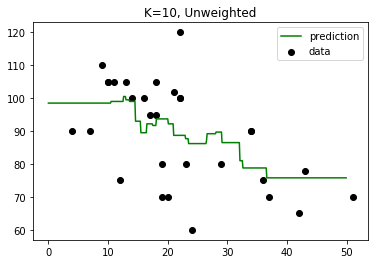

In [2]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

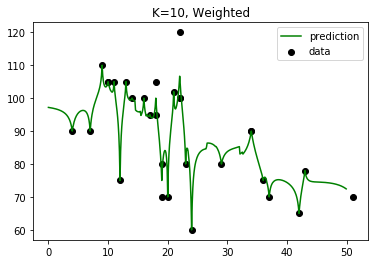

In [3]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

Notice how it seems like the weighted model grossly overfits to points. It is interesting that it oscillates around the datapoints. This is because the decay in weight happens so quickly.


## Validating KNN

Now validating KNN, whether a regression or a classifier, is pretty much exactly the same as evaluating other classifiers or regression. Cross validation is still tremendously valuable. You can do holdouts. You even still get an $R^2$ value for the regression.

Why don't we validate that overfitting of the previous model with some k-fold cross validation? The test statistic given by this model is $R^2$, which measures the same as in linear regression.

In [4]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.18 (+/- 0.66)
Weighted Accuracy: 0.11 (+/- 0.94)


First let me state that these two models are fantastically awful. There doesn't seem to be much of a relationship. It's all very poor. However the increased variance in the weighted model is interesting.

Why don't you add the other feature and mess around with $k$ and weighting to see if you can do any better than we've done so far?

# Tuning KNN

While KNN is a relatively simple model, there are several things we can do to tune its performance. These primarily have to do with how we handle distance and how many neighbors we include.

## Distance and Normalizing

We've talked about the distance measure we use for deciding how close other observations are to a test point, but when we did so we glossed over some important nuance in measuring distance. Specifically, the measurement makes the assumption that all units are equal. So, in our previous example, being 1 loudness unit away is equivalent to being 1 second away. This is intensely problematic and one of the main issues people have with KNN. Units are rarely equivalent, and discerning how to adjust that unequivalence is an abstract and touchy subject. This difficulty also makes binary or categorical variables nearly impossible to include in a KNN model. It really is best if they are continuous. 

It can be a more obvious challenge if you were dealing with something where the relative scales are strikingly different. For example, if you were looking at buildings and you have height in floors and square footage, you'd have a model that would really only care about square footage since distance in that dimension would be a far greater number of units than the number of floors.

To deal with this, typically data scientists will engage in something called __normalization__. Normalization is a way of taking these seemingly incommensurate measures and making them comparable. There are two main normalization techniques that are effective with KNN.

1. You can set the bounds of the data to 0 and 1, and then **rescale** every variable to be within those bounds (it may also be reasonable to do -1 to 1, but the difference is actually immaterial). This way every data point is measured in terms of its distance between the max and minimum of its category. This is best if the data shows a linear relationship, such that scaling to a 0 to 1 range makes logical sense. It is also best if there are known limits to the dataset, as those make for logical bounds for 0 and 1 for the rescaling.

2. You can also calculate how far each observation is from the mean, expressed in number of standard deviations: this is often called z-scores. Calculating z-scores and using them as your basis for measuring distance works for continuous data and puts everything in terms of how far from the mean (or "abnormal") it is.

Either of these techniques are viable for most situations and you'll have to use your intuition to see which makes the most sense. Mixing them, while possible, is usually a dangerous proposition.

## Weighting

There is one more thing to address when talking about distance, and that is weighting. In the vanilla version of KNN, all $k$ of the closest observations are given equal votes on what the outcome of our test observation should be. When the data is densely populated that isn't necessarily a problem. Particularly if there is variance in the measurement itself, not trying to draw information from small differences in distance can be wise.

However, sometimes the $k$ nearest observations are not all similarly close to the test. In that case it may be useful to weight by distance. Functionally this will weight by the inverse of distance, so that closer datapoints (with a low distance) have a higher weight than further ones.

SKLearn again makes this quite easy to implement. There is an optional weights parameter that can be used when defining the model. Set that parameter to "distance" and you will use distance weighting.

Let's try it below and see how it affects our model. In this example we'll also use the stats module from SciPy to convert our data to z-scores.

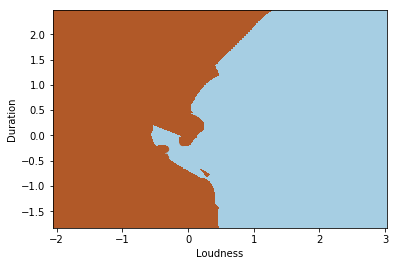

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Our input data frame will be the z-scores this time instead of raw data.
X = pd.DataFrame({
    'loudness': stats.zscore(music.loudness),
    'duration': stats.zscore(music.duration)
})

# Fit our model.
Y = music.jazz
neighbors.fit(X, Y)

# Arrays, not data frames, for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = .01

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:,0].min() - .5
x_max = X[:,0].max() + .5
y_min = X[:,1].min() - .5
y_max = X[:,1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

# Rescaling 

We are going to rescale every variable to be within 0 to 1 bounds

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


music
df_scaled = pd.DataFrame(scaler.fit_transform(music), columns=music.columns)
df_scaled

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,duration,loudness,bpm,jazz
0,0.272425,0.297872,0.750000,1.0
1,0.106312,0.638298,0.500000,0.0
2,0.468439,0.829787,0.300000,0.0
3,0.279070,0.680851,0.250000,0.0
4,0.066445,0.382979,1.000000,1.0
5,0.315615,0.106383,0.833333,1.0
6,0.637874,0.531915,0.333333,0.0
7,0.930233,0.382979,0.666667,1.0
8,0.000000,0.127660,0.750000,1.0
9,0.538206,0.425532,0.000000,0.0


In [39]:
from sklearn.neighbors import KNeighborsRegressor

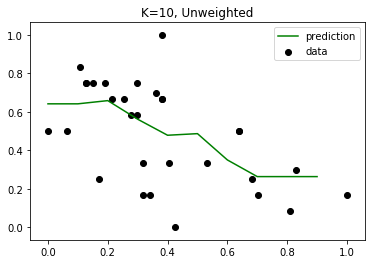

In [42]:
# Build our model.
knn = KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(df_scaled.loudness)
Y = df_scaled.bpm
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 1, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

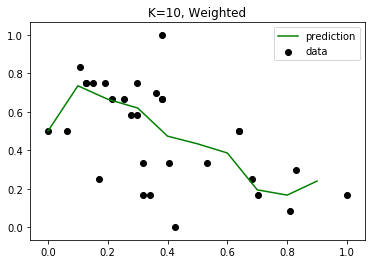

In [44]:
# Run the same model, this time with weights.
knn_w = KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(df_scaled.loudness)
Y = df_scaled.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 1, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

## Validating KNN

In [45]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.15 (+/- 0.56)
Weighted Accuracy: 0.12 (+/- 0.91)
